In [1]:
# !pip install PyPortfolioOpt

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta
import json
from requests import Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
from time import sleep
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
# Activate timer
start_time = time.time()

In [4]:
# Deactivate warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set visualization style and palette
sns.set_style('whitegrid')
my_palette = sns.color_palette("gist_earth")
sns.set_palette(my_palette)

In [6]:
# Set pandas output option
pd.options.display.max_columns = 50
pd.options.display.max_rows = 260

In [7]:
## Set the period for which to request information on stock prices
# analyze_years = 1

In [8]:
## Input the token
# access_key = "" # Get the key for 1,000 monthly requests for free using link https://marketstack.com/signup

In [9]:
## Get the symbols for the NASDAQ

# tickers_url = f"http://api.marketstack.com/v1/tickers?access_key={access_key}&limit=10309&exchange=XNAS"

# session = Session()

# try:
#     response = session.get(tickers_url) 
#     results = json.loads(response.text)
# except (ConnectionError, Timeout, TooManyRedirects) as e:
#     print(e)

# session.close()

# nasdaq_symbols = pd.DataFrame(results["data"])

# nasdaq_symbols["stock_exchange"] = "NASDAQ"

# nasdaq_symbols.to_excel("nasdaq_symbols.xlsx", index=False)

In [10]:
## Get the symbols for the NYSE

# tickers_url = f"http://api.marketstack.com/v1/tickers?access_key={access_key}&limit=10309&exchange=XNYS"

# session = Session()

# try:
#     response = session.get(tickers_url) 
#     results = json.loads(response.text)
# except (ConnectionError, Timeout, TooManyRedirects) as e:
#     print(e)
    
# session.close()

# nyse_symbols = pd.DataFrame(results["data"])

# nyse_symbols["stock_exchange"] = "NYSE"

# nyse_symbols.to_excel("nyse_symbols.xlsx", index=False)

In [11]:
## Filter symbols for which daily information is available 
# nasdaq_symbols = pd.read_excel("nasdaq_symbols.xlsx")
# nasdaq = nasdaq_symbols.loc[nasdaq_symbols["has_eod"] == True].reset_index(drop=True)

# nyse_symbols = pd.read_excel("nyse_symbols.xlsx")
# nyse = nyse_symbols.loc[nyse_symbols["has_eod"] == True].reset_index(drop=True)

## Create a data frame of 250 NASDAQ and 250 NYSE symbola
# symbols = nasdaq[:250].append(nyse[:250], ignore_index=True)

In [12]:
## Retrieve information on stock for each symbol 

# today = dt.today()

# analyze_days = 365 * analyze_years
# from_date = today - timedelta(days = analyze_days)

# today = today.strftime('%Y-%m-%d')

# from_date = from_date.strftime('%Y-%m-%d')

# symbols_lst = symbols["symbol"].to_list()

# stock_data = pd.DataFrame()

# for symbol in symbols_lst:
    
#     eod_url = f"http://api.marketstack.com/v1/eod?access_key={access_key}&symbols={symbol}&date_from={from_date}&date_to={today}&limit=10000"

#     session = Session()

#     try:
#         response = session.get(eod_url) 
#         results = json.loads(response.text)
#     except (ConnectionError, Timeout, TooManyRedirects) as e:
#         print(e)

#     session.close()
    
    
#     stock_data = stock_data.append(pd.DataFrame(results["data"]), ignore_index=True)
    
#     sleep(1.5)

# stock_data.to_excel("stock_data.xlsx", index=False)

In [13]:
## Read saved information from the file
stock_data = pd.read_excel("stock_data.xlsx")

In [14]:
# Check the data frame 
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124690 entries, 0 to 124689
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   index         124690 non-null  int64  
 1   open          124686 non-null  float64
 2   high          124690 non-null  float64
 3   low           124690 non-null  float64
 4   close         124686 non-null  float64
 5   volume        124642 non-null  float64
 6   adj_high      116740 non-null  float64
 7   adj_low       116740 non-null  float64
 8   adj_close     124690 non-null  float64
 9   adj_open      116740 non-null  float64
 10  adj_volume    116707 non-null  float64
 11  split_factor  124690 non-null  float64
 12  symbol        124690 non-null  object 
 13  exchange      124690 non-null  object 
 14  date          124690 non-null  object 
dtypes: float64(11), int64(1), object(3)
memory usage: 14.3+ MB


In [15]:
stock_data.describe()

,index,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor
count,124690.000000,124686.000000,124690.000000,124690.000000,124686.000000,1.246420e+05,116740.000000,116740.000000,124690.000000,116740.000000,1.167070e+05,124690.000000
mean,61585.181177,148.457434,150.543798,146.252497,148.431188,5.260678e+06,148.171605,143.931707,147.043465,146.116486,5.472139e+06,1.000171
std,35987.036964,236.475285,239.765803,232.900084,236.397501,1.179895e+07,236.897210,230.135319,234.166179,233.661160,1.286704e+07,0.022515
min,0.000000,0.415000,0.424000,0.408000,0.420000,0.000000e+00,1.210000,1.170000,0.420000,1.200000,0.000000e+00,1.000000
25%,30408.250000,43.470000,44.060000,42.870000,43.450000,8.490788e+05,43.649781,42.480000,43.380000,43.060000,8.698380e+05,1.000000
50%,61580.500000,86.550000,87.710000,85.310000,86.520000,1.877322e+06,86.470000,84.100492,86.250000,85.280000,1.926087e+06,1.000000
75%,92752.750000,172.000000,174.417500,169.427500,171.940000,4.643818e+06,171.620000,166.680000,170.500000,169.220000,4.720872e+06,1.000000
max,123925.000000,3547.000000,3552.250000,3486.685000,3531.450000,4.286171e+08,3552.250000,3486.685000,3531.450000,3547.000000,4.286171e+08,5.000000


In [16]:
# Create a data frame with necessary columns
data = stock_data[["date", "symbol", "adj_close"]]

In [17]:
# Transform the dates from ISO format
data['date'] = [x[:10] for x in data['date']]

In [18]:
# Transform the data frame into the wide form
data_wide = data.pivot_table(index='date', columns='symbol', values='adj_close').reset_index().set_index("date")

In [19]:
# Check missing values
data_wide.isnull().sum().sum()

1810

In [20]:
# Create a list of columns with more than one missing value
del_col = data_wide.loc[:, data_wide.isnull().sum() > 1].columns.to_list()

In [21]:
# Append the list with the columns with very high volatility
del_col = del_col + data_wide.loc[:, data_wide.max() / data_wide.min() > 10].columns.to_list()

In [22]:
# Remove columns with many missing and highly volatile values
data_wide.drop(del_col, axis=1, inplace=True)

In [23]:
# Create a list of rows with all missing values
del_row = data_wide[data_wide.sum(axis=1) == 0].index

In [24]:
# Remove rows with missing values
data_wide.drop(index=del_row, axis=0, inplace=True)

In [25]:
# Check missing values
data_wide.isnull().sum().sum()

0

In [26]:
# Create training data set
stock_prices = data_wide.iloc[:int(len(data_wide) / 2), :]

In [27]:
# Create testing data set
stock_prices_test = data_wide.iloc[int(len(data_wide) / 2):, :]

In [28]:
# Create customized function for combining portfolio
def create_portfolio(stock_prices, stock_prices_test, portfolio_value=10000,
                     upper_bound=0.2, risk_free_rate=0.03, frequency=252,
                     span=10, criteria="Sharpe"): 
    """
    The function optimizes portfolio according to the chosen criteria using stock_prices and validates 
    portfolio performance using stock_prices_test. 
    Returns weights as Pandas DataFrame, annual returns as decimal, and values of portfolio for all days in
    the testing data frame as named Pandas Series.
    
    Parameters
    ----------
    stock_prices:      pandas DataFrame, training data set
    stock_prices_test: pandas DataFrame, testing data set
    portfolio_value:   int or decimal, amount of money available for purchasing stock, default value 10000
    upper_bound:       decimal, maximum share of amount to be invested in one stock, default value 0.2
    risk_free_rate:    decimal, minimal returns, default value 0.03
    frequency:         int, quantity of trading days, default value 252
    span:              quantity of days for the purpose of exponential covariance, defaul value 10
    criteria:          str, the approach to portfolio optimization, possible values:
                            "Sharpe" - Sharpe ratio maximization 
                            "Sortino" - Sortino ratio maximization 
                            "Volatility" - Volatility minimization 
    """
    
    # Check argument validity
    if criteria not in ("Sharpe", "Sortino", "Volatility"):
        print("Please specify the valid argument. Criteria must be \"Sharpe\", \"Sortino\" or \"Volatility\".")
    
    # Define exponentially weighted Sigma and mu
    if criteria == "Sortino":
        Sigma = risk_models.semicovariance(stock_prices, span=span, benchmark=0, frequency=frequency)
    else:
        Sigma = risk_models.exp_cov(stock_prices, span=span, frequency=frequency)   
    mu = expected_returns.ema_historical_return(stock_prices, frequency=frequency, span=span)

    # Calculate the efficient frontier
    ef = EfficientFrontier(mu, Sigma, weight_bounds=(0.0, upper_bound))

    # Calculate weights for the maximum Sharpe ratio, Sortino ratio or minimum volatility optimization
    if criteria == "Volatility":
        ef.min_volatility()
    else:
        ef.max_sharpe(risk_free_rate=risk_free_rate)    
    weights = ef.clean_weights()
    
    # Create a data frame of weights
    weights_df = pd.DataFrame([weights.keys(), weights.values()], index=["symbol", "weight"]).T
    weights_df.drop(weights_df[weights_df["weight"] == 0].index, inplace=True)
    weights_df.reset_index(inplace=True, drop=True)

    # Get last prices from training data set
    latest_prices = get_latest_prices(stock_prices)

    # Allocate funds
    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=portfolio_value)
    allocation, leftover = da.greedy_portfolio()

    # Initial value of portfolio
    portfolio_value_real = round(portfolio_value - leftover, 2)

    # Stock values by days
    stock_values_test = stock_prices_test[list(allocation.keys())] * list(allocation.values())

    # Portfolio values by days
    stock_values_test["value"] = stock_values_test.sum(axis=1)
    
    # Final value of portfolio
    new_portfolio_value = round(stock_values_test["value"][-1], 2)
    
    # Annual returns
    annual_returns = \
        round((new_portfolio_value - portfolio_value) / portfolio_value / len(stock_prices_test) * 252, 4)
    
    return weights_df, annual_returns, stock_values_test["value"]

In [29]:
# Set parameters
portfolio_value = 10000
upper_bound = 0.2
risk_free_rate = 0.03
frequency = 252
span = 180
criteria = "Sharpe"

In [30]:
# Run the function
weights_sharpe_180, annual_returns_sharpe_180, portfolio_values_sharpe_180 = create_portfolio(stock_prices, 
                                                                                              stock_prices_test, 
                                                                                              portfolio_value,
                                                                                              upper_bound, 
                                                                                              risk_free_rate, 
                                                                                              frequency,
                                                                                              span, 
                                                                                              criteria)

In [31]:
# Check weights
weights_sharpe_180

,symbol,weight
0,BGNE,0.08312
1,CHT,0.16496
2,DISCB,0.01422
3,DUK,0.01658
4,ED,0.06417
5,FDX,0.2
6,LBTYB,0.01582
7,LOGI,0.01517
8,LSXMB,0.03056
9,MLCO,0.0137


In [32]:
def changes_in_portfolio_value(portfolio_values, criteria, span, weights, annual_returns, size = (8, 4)):
    """Graph of changes in the portfolio value
    """
    fig, ax = plt.subplots(figsize=size)
    g = sns.lineplot(data=portfolio_values)
    g.set_xticklabels(portfolio_values.index)
    for i, label in enumerate(g.get_xticklabels()):
        if i % 25 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    ax.grid(False, axis="x")
    g.set_title(f"The Value of Portfolio. {criteria}, Span {span} days, {weights.shape[0]} Shares, Annual Returns {annual_returns * 100:.2f}%")
    g.set_xlabel("Date")
    g.set_ylabel("Value")
    plt.show()

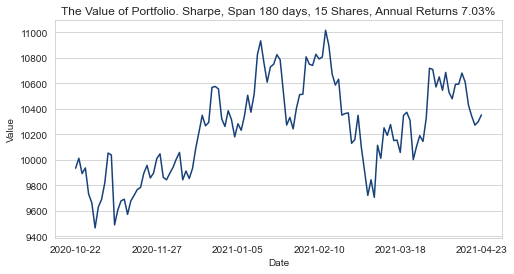

In [33]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_sharpe_180, 
                           criteria, 
                           span, 
                           weights_sharpe_180, 
                           annual_returns_sharpe_180)

In [34]:
# Set parameters
span = 180
criteria = "Sortino"

In [35]:
# Run the function
weights_sortino_180, annual_returns_sortino_180, portfolio_values_sortino_180 = \
                                                                        create_portfolio(stock_prices, 
                                                                                         stock_prices_test, 
                                                                                         portfolio_value,
                                                                                         upper_bound, 
                                                                                         risk_free_rate, 
                                                                                         frequency,
                                                                                         span, 
                                                                                         criteria)

In [36]:
# Check weights
weights_sortino_180

,symbol,weight
0,CHT,0.2
1,FDX,0.2
2,MCD,0.06834
3,PG,0.02398
4,PTON,0.2
5,TGT,0.10768
6,ZM,0.2


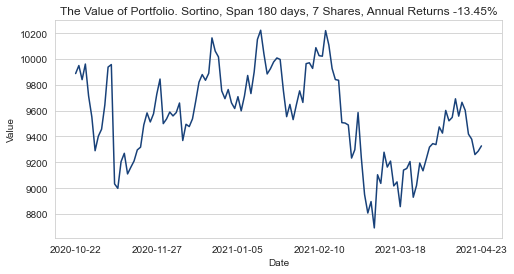

In [37]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_sortino_180, 
                           criteria, 
                           span, 
                           weights_sortino_180, 
                           annual_returns_sortino_180)

In [38]:
# Set parameters
span = 180
criteria = "Volatility"

In [39]:
# Run the function
weights_volat_180, annual_returns_volat_180, portfolio_values_volat_180 = create_portfolio(stock_prices, 
                                                                                           stock_prices_test, 
                                                                                           portfolio_value,
                                                                                           upper_bound, 
                                                                                           risk_free_rate, 
                                                                                           frequency,
                                                                                           span, 
                                                                                           criteria)

In [40]:
# Check weights
weights_volat_180

,symbol,weight
0,AGNC,0.03713
1,AZN,0.02683
2,BAX,0.0239
3,BDX,0.02832
4,BIDU,0.0161
5,CHT,0.2
6,COST,0.03118
7,DCUE,0.16708
8,DG,0.00299
9,DISCB,0.02193


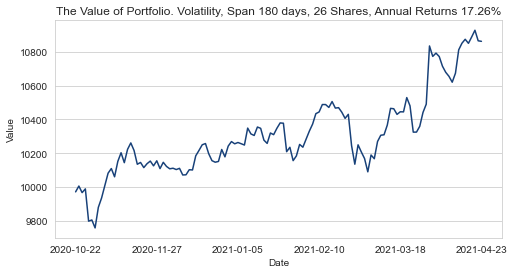

In [41]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_volat_180, 
                           criteria, 
                           span, 
                           weights_volat_180, 
                           annual_returns_volat_180)

In [42]:
# Set parameters
span = 90
criteria = "Sharpe"

In [43]:
# Run the function
weights_sharpe_90, annual_returns_sharpe_90, portfolio_values_sharpe_90 = create_portfolio(stock_prices, 
                                                                                           stock_prices_test, 
                                                                                           portfolio_value,
                                                                                           upper_bound, 
                                                                                           risk_free_rate, 
                                                                                           frequency,
                                                                                           span, 
                                                                                           criteria)

In [44]:
# Check weights
weights_sharpe_90

,symbol,weight
0,BGNE,0.06314
1,CAJ,0.00439
2,CHT,0.11447
3,DISCB,0.00072
4,DUK,0.06282
5,ED,0.01684
6,ERIC,0.06288
7,EXAS,0.00045
8,F,0.0038
9,FDX,0.2


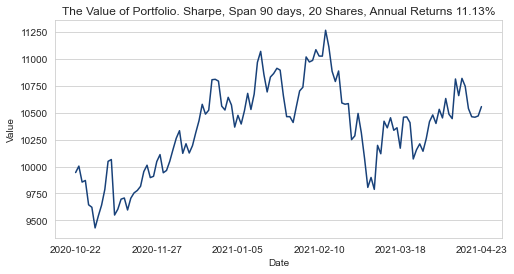

In [45]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_sharpe_90, 
                           criteria, 
                           span, 
                           weights_sharpe_90, 
                           annual_returns_sharpe_90)

In [46]:
# Set parameters
span = 90
criteria = "Sortino"

In [47]:
# Run the function
weights_sortino_90, annual_returns_sortino_90, portfolio_values_sortino_90 = create_portfolio(stock_prices, 
                                                                                              stock_prices_test, 
                                                                                              portfolio_value,
                                                                                              upper_bound, 
                                                                                              risk_free_rate, 
                                                                                              frequency,
                                                                                              span, 
                                                                                              criteria)

In [48]:
# Check weights
weights_sortino_90

,symbol,weight
0,CHT,0.2
1,FDX,0.2
2,LOGI,0.17129
3,MCD,0.00695
4,NVCR,0.02176
5,PTON,0.2
6,ZM,0.2


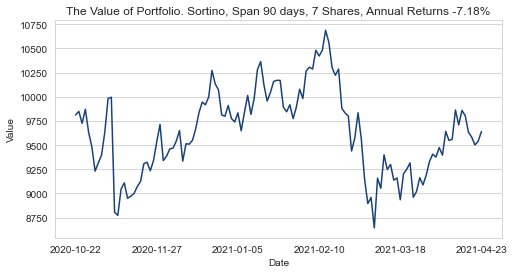

In [49]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_sortino_90, 
                           criteria, 
                           span, 
                           weights_sortino_90, 
                           annual_returns_sortino_90)

In [50]:
# Set parameters
span = 90
criteria = "Volatility"

In [51]:
# Run the function
weights_volat_90, annual_returns_volat_90, portfolio_values_volat_90 = create_portfolio(stock_prices, 
                                                                                        stock_prices_test, 
                                                                                        portfolio_value,
                                                                                        upper_bound, 
                                                                                        risk_free_rate, 
                                                                                        frequency,
                                                                                        span, 
                                                                                        criteria)

In [52]:
# Check weights
weights_volat_90

,symbol,weight
0,AGNC,0.038
1,AZN,0.01675
2,BAX,0.03288
3,BDX,0.0283
4,BIDU,0.02471
5,CHT,0.2
6,DCUE,0.2
7,DISCB,0.02796
8,IQ,0.00352
9,KMB,0.01288


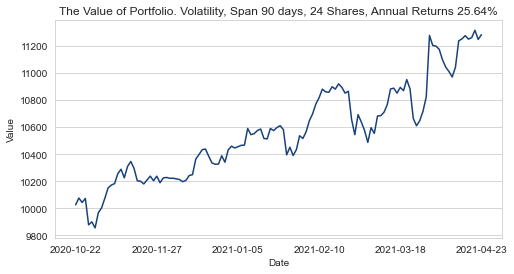

In [53]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_volat_90, 
                           criteria, 
                           span, 
                           weights_volat_90, 
                           annual_returns_volat_90)

In [54]:
# Set parameters
span = 30
criteria = "Sharpe"

In [55]:
# Run the function
weights_sharpe_30, annual_returns_sharpe_30, portfolio_values_sharpe_30 = create_portfolio(stock_prices, 
                                                                                           stock_prices_test, 
                                                                                           portfolio_value,
                                                                                           upper_bound, 
                                                                                           risk_free_rate, 
                                                                                           frequency,
                                                                                           span, 
                                                                                           criteria)

In [56]:
# Check weights
weights_sharpe_30

,symbol,weight
0,AEP,0.1118
1,DISCB,0.01073
2,ERIC,0.2
3,EXAS,0.01497
4,HDB,0.05569
5,IBM,0.02927
6,LOGI,0.1787
7,PM,0.03526
8,PTON,0.09447
9,ROKU,0.01017


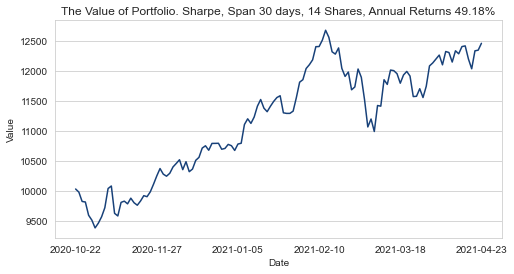

In [57]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_sharpe_30, 
                           criteria, 
                           span, 
                           weights_sharpe_30, 
                           annual_returns_sharpe_30)

In [58]:
# Set parameters
span = 30
criteria = "Sortino"

In [59]:
# Run the function
weights_sortino_30, annual_returns_sortino_30, portfolio_values_sortino_30 = create_portfolio(stock_prices, 
                                                                                              stock_prices_test, 
                                                                                              portfolio_value,
                                                                                              upper_bound, 
                                                                                              risk_free_rate, 
                                                                                              frequency,
                                                                                              span, 
                                                                                              criteria)

In [60]:
# Check weights
weights_sortino_30

,symbol,weight
0,CHT,0.2
1,COST,0.08612
2,DCUE,0.04661
3,ERIC,0.2
4,GM,0.01018
5,HDB,0.12135
6,LOGI,0.2
7,PTON,0.13573


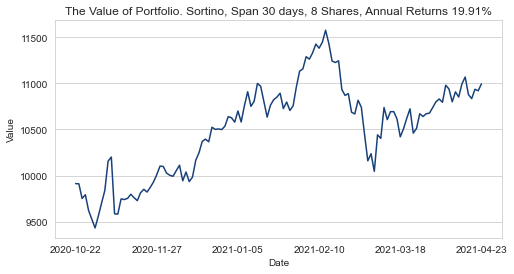

In [61]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_sortino_30, 
                           criteria, 
                           span, 
                           weights_sortino_30, 
                           annual_returns_sortino_30)

In [62]:
# Set parameters
span = 30
criteria = "Volatility"

In [63]:
# Run the function
weights_volat_30, annual_returns_volat_30, portfolio_values_volat_30 = create_portfolio(stock_prices, 
                                                                                        stock_prices_test, 
                                                                                        portfolio_value,
                                                                                        upper_bound, 
                                                                                        risk_free_rate, 
                                                                                        frequency,
                                                                                        span, 
                                                                                        criteria)

In [64]:
# Check weights
weights_volat_30

,symbol,weight
0,BAX,0.04898
1,BIDU,0.04774
2,CHT,0.2
3,CP,0.02063
4,DCUE,0.2
5,DISCB,0.058
6,IQ,0.01029
7,JBHT,0.00152
8,LSXMB,0.01329
9,MFG,0.00331


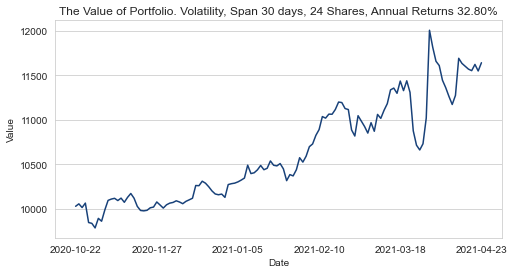

In [65]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_volat_30, 
                           criteria, 
                           span, 
                           weights_volat_30, 
                           annual_returns_volat_30)

In [66]:
# Set parameters
span = 10
criteria = "Sharpe"

In [67]:
# Run the function
weights_sharpe_10, annual_returns_sharpe_10, portfolio_values_sharpe_10 = create_portfolio(stock_prices, 
                                                                                           stock_prices_test, 
                                                                                           portfolio_value,
                                                                                           upper_bound, 
                                                                                           risk_free_rate, 
                                                                                           frequency,
                                                                                           span, 
                                                                                           criteria)

In [68]:
# Check weights
weights_sharpe_10

,symbol,weight
0,AAPL,0.0004
1,ABB,0.0004
2,ABBV,0.00045
3,ABEV,0.00037
4,ABT,0.00027
...,...,...
432,ZBH,0.00011
433,ZBRA,0.00055
434,ZG,-0.00059
435,ZM,0.09318


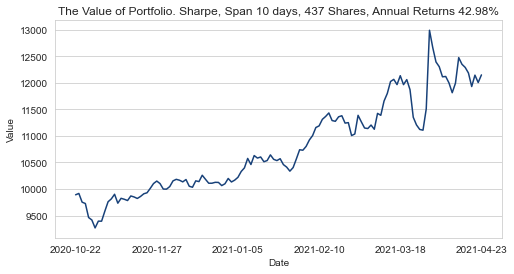

In [69]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_sharpe_10, 
                           criteria, 
                           span, 
                           weights_sharpe_10, 
                           annual_returns_sharpe_10)

In [70]:
# Set parameters
span = 10
criteria = "Sortino"

In [71]:
# Run the function
weights_sortino_10, annual_returns_sortino_10, portfolio_values_sortino_10 = create_portfolio(stock_prices, 
                                                                                              stock_prices_test, 
                                                                                              portfolio_value,
                                                                                              upper_bound, 
                                                                                              risk_free_rate, 
                                                                                              frequency,
                                                                                              span, 
                                                                                              criteria)

In [72]:
# Check weights
weights_sortino_10

,symbol,weight
0,CHT,0.2
1,COST,0.11196
2,DCUE,0.12913
3,ERIC,0.2
4,LOGI,0.2
5,PG,0.09825
6,VZ,0.06066


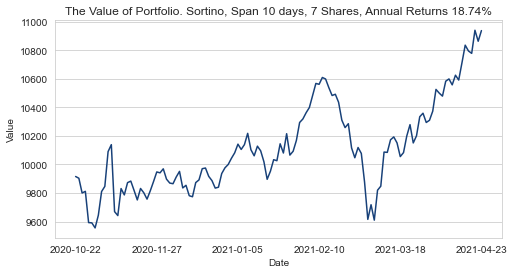

In [73]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_sortino_10, 
                           criteria, 
                           span, 
                           weights_sortino_10, 
                           annual_returns_sortino_10)

In [74]:
# Set parameters
span = 10
criteria = "Volatility"

In [75]:
# Run the function
weights_volat_10, annual_returns_volat_10, portfolio_values_volat_10 = create_portfolio(stock_prices, 
                                                                                        stock_prices_test, 
                                                                                        portfolio_value,
                                                                                        upper_bound, 
                                                                                        risk_free_rate, 
                                                                                        frequency,
                                                                                        span, 
                                                                                        criteria)

In [76]:
# Check weights
weights_volat_10

,symbol,weight
0,BAX,0.03259
1,BIDU,0.06199
2,CHT,0.2
3,DCUE,0.1173
4,DISCB,0.14568
5,ERIC,0.01355
6,GH,0.00386
7,LOGI,0.00426
8,MLCO,0.03368
9,MSCI,0.06739


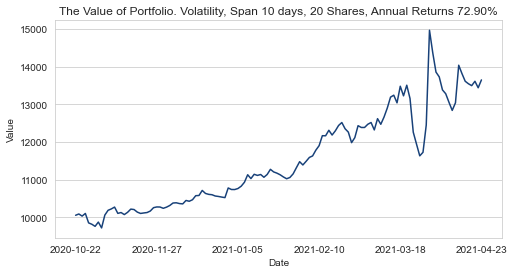

In [77]:
# Graph of changes in the portfolio value
changes_in_portfolio_value(portfolio_values_volat_10, 
                           criteria, 
                           span, 
                           weights_volat_10, 
                           annual_returns_volat_10)

In [78]:
def comparison_chart(visual_df, size=(16, 9)):    
    """Plot the comparison chart
    """

    # Create the figure
    fig, ax = plt.subplots(figsize=size)

    # Create the chart
    g = sns.lineplot(data=visual_df)

    # Set x-axis range
    g.set_xticks(range(len(visual_df)))

    # Set ticks
    g.set_xticklabels(visual_df["index"])
    for i, label in enumerate(g.get_xticklabels()):
        if i % 25 == 0:  # every 25th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

    # Set title and axis labels
    g.set_title("The Value of Portfolios Composed on the Basis of Different Criteria")
    g.set_xlabel("Date")
    g.set_ylabel("Value")

    # Hide the vertical grid lines
    ax.grid(False, axis="x")

    # Show the chart
    plt.show()

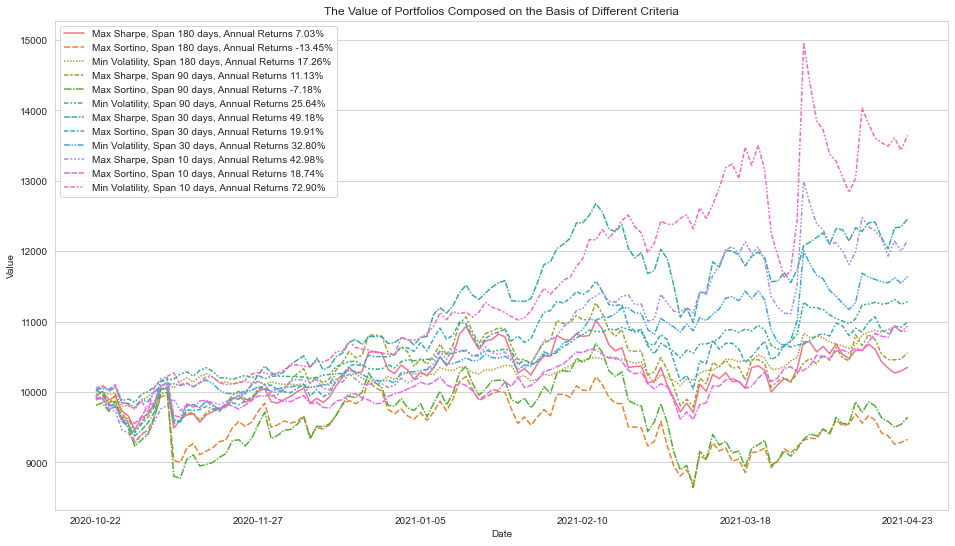

In [79]:
# Create a data frame for all scenarios
visual_df = \
pd.DataFrame(zip(portfolio_values_sharpe_180, portfolio_values_sortino_180, portfolio_values_volat_180,
                 portfolio_values_sharpe_90, portfolio_values_sortino_90, portfolio_values_volat_90,
                 portfolio_values_sharpe_30, portfolio_values_sortino_30, portfolio_values_volat_30,
                 portfolio_values_sharpe_10, portfolio_values_sortino_10, portfolio_values_volat_10),
             index=portfolio_values_sharpe_180.index.to_list(),
             columns=[f"Max Sharpe, Span 180 days, Annual Returns {annual_returns_sharpe_180 * 100:.2f}%", 
                      f"Max Sortino, Span 180 days, Annual Returns {annual_returns_sortino_180 * 100:.2f}%", 
                      f"Min Volatility, Span 180 days, Annual Returns {annual_returns_volat_180 * 100:.2f}%",
                      f"Max Sharpe, Span 90 days, Annual Returns {annual_returns_sharpe_90 * 100:.2f}%", 
                      f"Max Sortino, Span 90 days, Annual Returns {annual_returns_sortino_90 * 100:.2f}%", 
                      f"Min Volatility, Span 90 days, Annual Returns {annual_returns_volat_90 * 100:.2f}%",
                      f"Max Sharpe, Span 30 days, Annual Returns {annual_returns_sharpe_30 * 100:.2f}%", 
                      f"Max Sortino, Span 30 days, Annual Returns {annual_returns_sortino_30 * 100:.2f}%", 
                      f"Min Volatility, Span 30 days, Annual Returns {annual_returns_volat_30 * 100:.2f}%",
                      f"Max Sharpe, Span 10 days, Annual Returns {annual_returns_sharpe_10 * 100:.2f}%", 
                      f"Max Sortino, Span 10 days, Annual Returns {annual_returns_sortino_10 * 100:.2f}%", 
                      f"Min Volatility, Span 10 days, Annual Returns {annual_returns_volat_10 * 100:.2f}%"])

# Reset index
visual_df.reset_index(inplace=True, drop=False)

# Call the function to plot the comparison chart
comparison_chart(visual_df=visual_df)

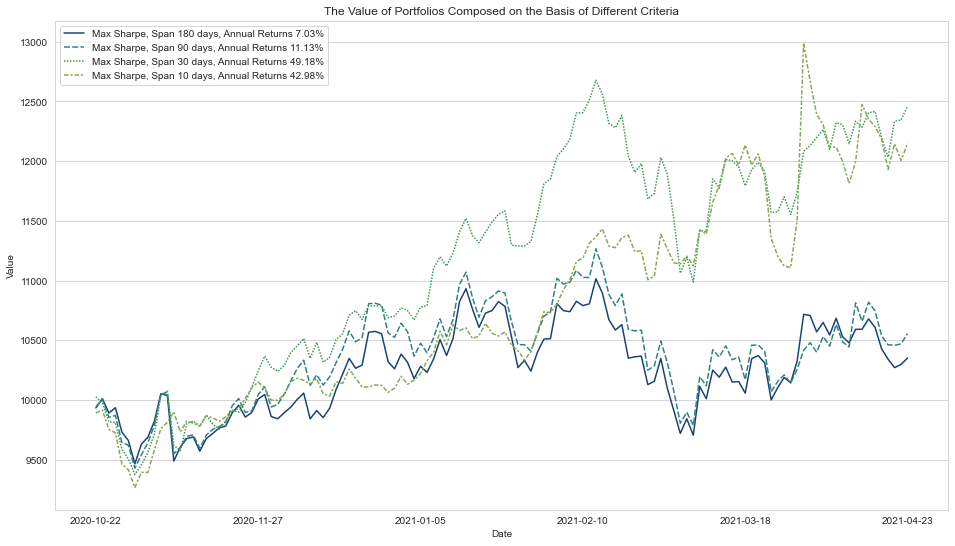

In [80]:
# Create a data frame for all Sharpe scenarios
visual_df = \
pd.DataFrame(zip(portfolio_values_sharpe_180,
                 portfolio_values_sharpe_90,
                 portfolio_values_sharpe_30,
                 portfolio_values_sharpe_10),
             index=portfolio_values_sharpe_180.index.to_list(),
             columns=[f"Max Sharpe, Span 180 days, Annual Returns {annual_returns_sharpe_180 * 100:.2f}%", 
                      f"Max Sharpe, Span 90 days, Annual Returns {annual_returns_sharpe_90 * 100:.2f}%", 
                      f"Max Sharpe, Span 30 days, Annual Returns {annual_returns_sharpe_30 * 100:.2f}%", 
                      f"Max Sharpe, Span 10 days, Annual Returns {annual_returns_sharpe_10 * 100:.2f}%"])

# Reset index
visual_df.reset_index(inplace=True, drop=False)

# Call the function to plot the comparison chart
comparison_chart(visual_df=visual_df)

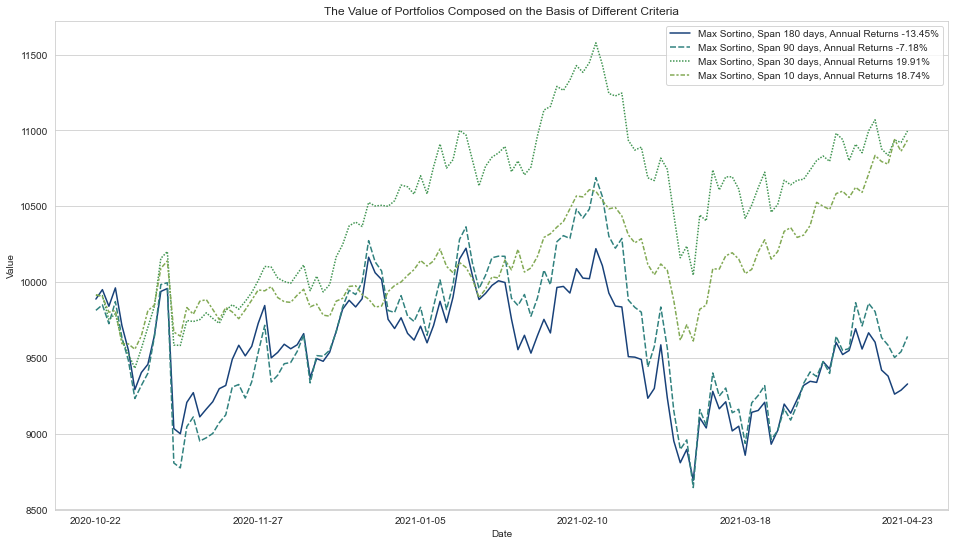

In [81]:
# Create a data frame for all Sortino scenarios
visual_df = \
pd.DataFrame(zip(portfolio_values_sortino_180,
                 portfolio_values_sortino_90,
                 portfolio_values_sortino_30,
                 portfolio_values_sortino_10),
             index=portfolio_values_sharpe_180.index.to_list(),
             columns=[f"Max Sortino, Span 180 days, Annual Returns {annual_returns_sortino_180 * 100:.2f}%", 
                      f"Max Sortino, Span 90 days, Annual Returns {annual_returns_sortino_90 * 100:.2f}%", 
                      f"Max Sortino, Span 30 days, Annual Returns {annual_returns_sortino_30 * 100:.2f}%", 
                      f"Max Sortino, Span 10 days, Annual Returns {annual_returns_sortino_10 * 100:.2f}%"])

# Reset index
visual_df.reset_index(inplace=True, drop=False)

# Call the function to plot the comparison chart
comparison_chart(visual_df=visual_df)

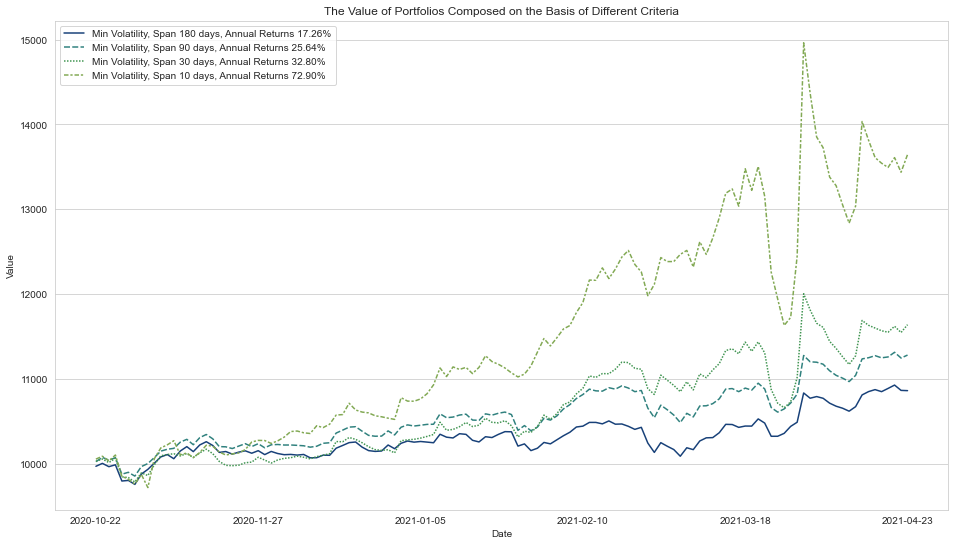

In [82]:
# Create a data frame for all Volatility scenarios
visual_df = \
pd.DataFrame(zip(portfolio_values_volat_180,
                 portfolio_values_volat_90,
                 portfolio_values_volat_30,
                 portfolio_values_volat_10),
             index=portfolio_values_sharpe_180.index.to_list(),
             columns=[f"Min Volatility, Span 180 days, Annual Returns {annual_returns_volat_180 * 100:.2f}%",
                      f"Min Volatility, Span 90 days, Annual Returns {annual_returns_volat_90 * 100:.2f}%",
                      f"Min Volatility, Span 30 days, Annual Returns {annual_returns_volat_30 * 100:.2f}%",
                      f"Min Volatility, Span 10 days, Annual Returns {annual_returns_volat_10 * 100:.2f}%"])

# Reset index
visual_df.reset_index(inplace=True, drop=False)

# Call the function to plot the comparison chart
comparison_chart(visual_df=visual_df)

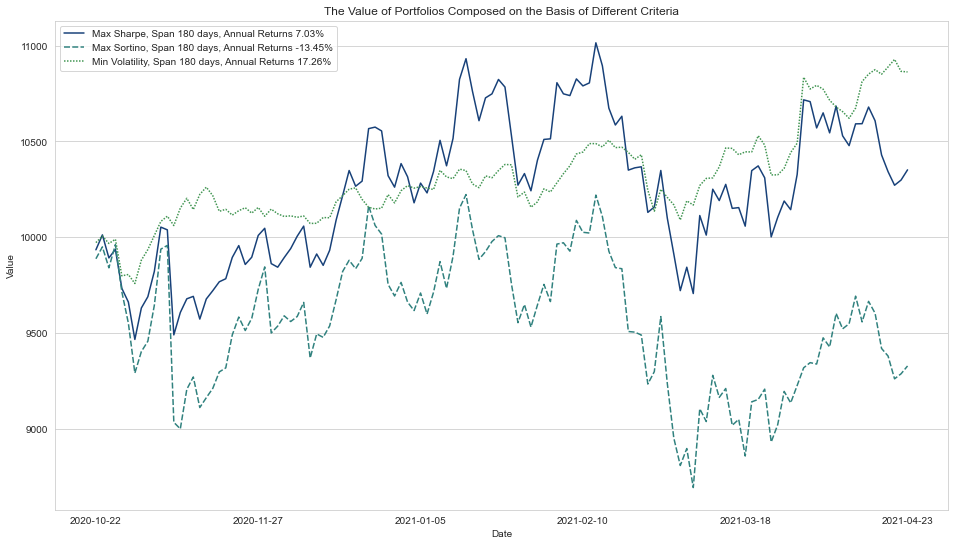

In [83]:
# Create a data frame for all 180 days scenarios
visual_df = \
pd.DataFrame(zip(portfolio_values_sharpe_180, portfolio_values_sortino_180, portfolio_values_volat_180),
             index=portfolio_values_sharpe_180.index.to_list(),
             columns=[f"Max Sharpe, Span 180 days, Annual Returns {annual_returns_sharpe_180 * 100:.2f}%", 
                      f"Max Sortino, Span 180 days, Annual Returns {annual_returns_sortino_180 * 100:.2f}%", 
                      f"Min Volatility, Span 180 days, Annual Returns {annual_returns_volat_180 * 100:.2f}%"])

# Reset index
visual_df.reset_index(inplace=True, drop=False)

# Call the function to plot the comparison chart
comparison_chart(visual_df=visual_df)

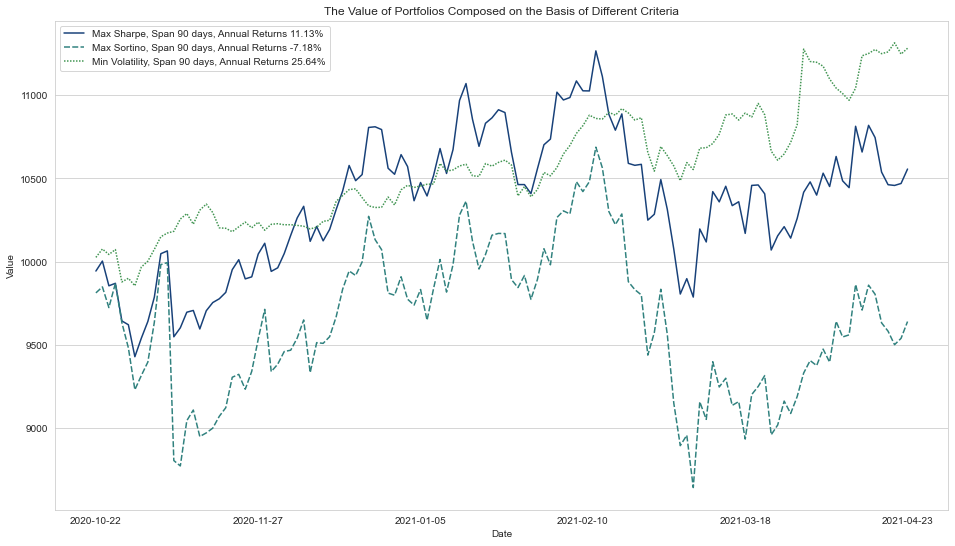

In [84]:
# Create a data frame for all 90 days scenarios
visual_df = \
pd.DataFrame(zip(portfolio_values_sharpe_90, portfolio_values_sortino_90, portfolio_values_volat_90),
             index=portfolio_values_sharpe_180.index.to_list(),
             columns=[f"Max Sharpe, Span 90 days, Annual Returns {annual_returns_sharpe_90 * 100:.2f}%", 
                      f"Max Sortino, Span 90 days, Annual Returns {annual_returns_sortino_90 * 100:.2f}%", 
                      f"Min Volatility, Span 90 days, Annual Returns {annual_returns_volat_90 * 100:.2f}%"])

# Reset index
visual_df.reset_index(inplace=True, drop=False)

# Call the function to plot the comparison chart
comparison_chart(visual_df=visual_df)

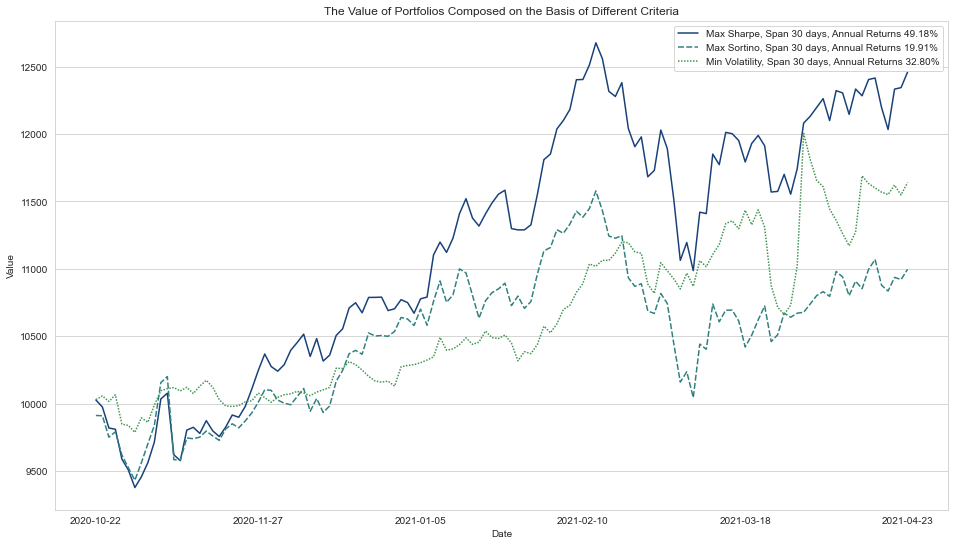

In [85]:
# Create a data frame for all 30 days scenarios
visual_df = \
pd.DataFrame(zip(portfolio_values_sharpe_30, portfolio_values_sortino_30, portfolio_values_volat_30),
             index=portfolio_values_sharpe_180.index.to_list(),
             columns=[f"Max Sharpe, Span 30 days, Annual Returns {annual_returns_sharpe_30 * 100:.2f}%", 
                      f"Max Sortino, Span 30 days, Annual Returns {annual_returns_sortino_30 * 100:.2f}%", 
                      f"Min Volatility, Span 30 days, Annual Returns {annual_returns_volat_30 * 100:.2f}%"])

# Reset index
visual_df.reset_index(inplace=True, drop=False)

# Call the function to plot the comparison chart
comparison_chart(visual_df=visual_df)

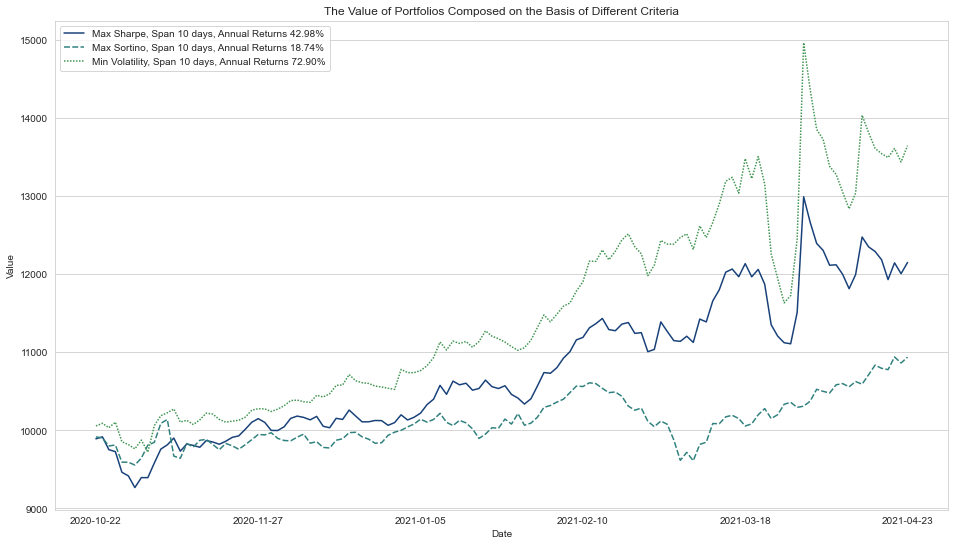

In [86]:
# Create a data frame for all scenarios
visual_df = \
pd.DataFrame(zip(portfolio_values_sharpe_10, portfolio_values_sortino_10, portfolio_values_volat_10),
             index=portfolio_values_sharpe_180.index.to_list(),
             columns=[f"Max Sharpe, Span 10 days, Annual Returns {annual_returns_sharpe_10 * 100:.2f}%", 
                      f"Max Sortino, Span 10 days, Annual Returns {annual_returns_sortino_10 * 100:.2f}%", 
                      f"Min Volatility, Span 10 days, Annual Returns {annual_returns_volat_10 * 100:.2f}%"])

# Reset index
visual_df.reset_index(inplace=True, drop=False)

# Call the function to plot the comparison chart
comparison_chart(visual_df=visual_df)

In [87]:
# Stop the timer and print the script runtime 
end_time = time.time()
print(f"Script running time: {round((end_time - start_time), 1)} s")

Script running time: 1170.5 s
